D:\Publish Paper\ML in Cyber_ash\Plant_disease_detector\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1, Train Loss: 1.6394996885626252, Validation Loss: 1.210497519757488, Train Accuracy: 41.16002795248078%, Validation Accuracy: 54.3728602552132%
Epoch 2, Train Loss: 1.2437980873117376, Validation Loss: 1.0537323526816793, Train Accuracy: 55.827315785387064%, Validation Accuracy: 63.087457205104265%
Epoch 3, Train Loss: 1.0992648665129992, Validation Loss: 0.9875555513518872, Train Accuracy: 61.052876776147215%, Validation Accuracy: 65.11048863990041%
Epoch 4, Train Loss: 1.0091180020467223, Validation Loss: 0.945889908414666, Train Accuracy: 63.47542511064523%, Validation Accuracy: 64.76812947401183%
Epoch 5, Train Loss: 0.9259230838372157, Validation Loss: 0.8027246812598245, Train Accuracy: 66.50361052876777%, Validation Accuracy: 70.0280112044818%
Epoch 6, Train Loss: 0.8461091021450222, Validation Loss: 0.802061885226481, Train Accuracy: 69.87343737867847%, Validation Accuracy: 70.1525054466231%
Epoch 7, Train Loss: 0.7976127364499397, Validation Loss: 0.7427699244996109, T

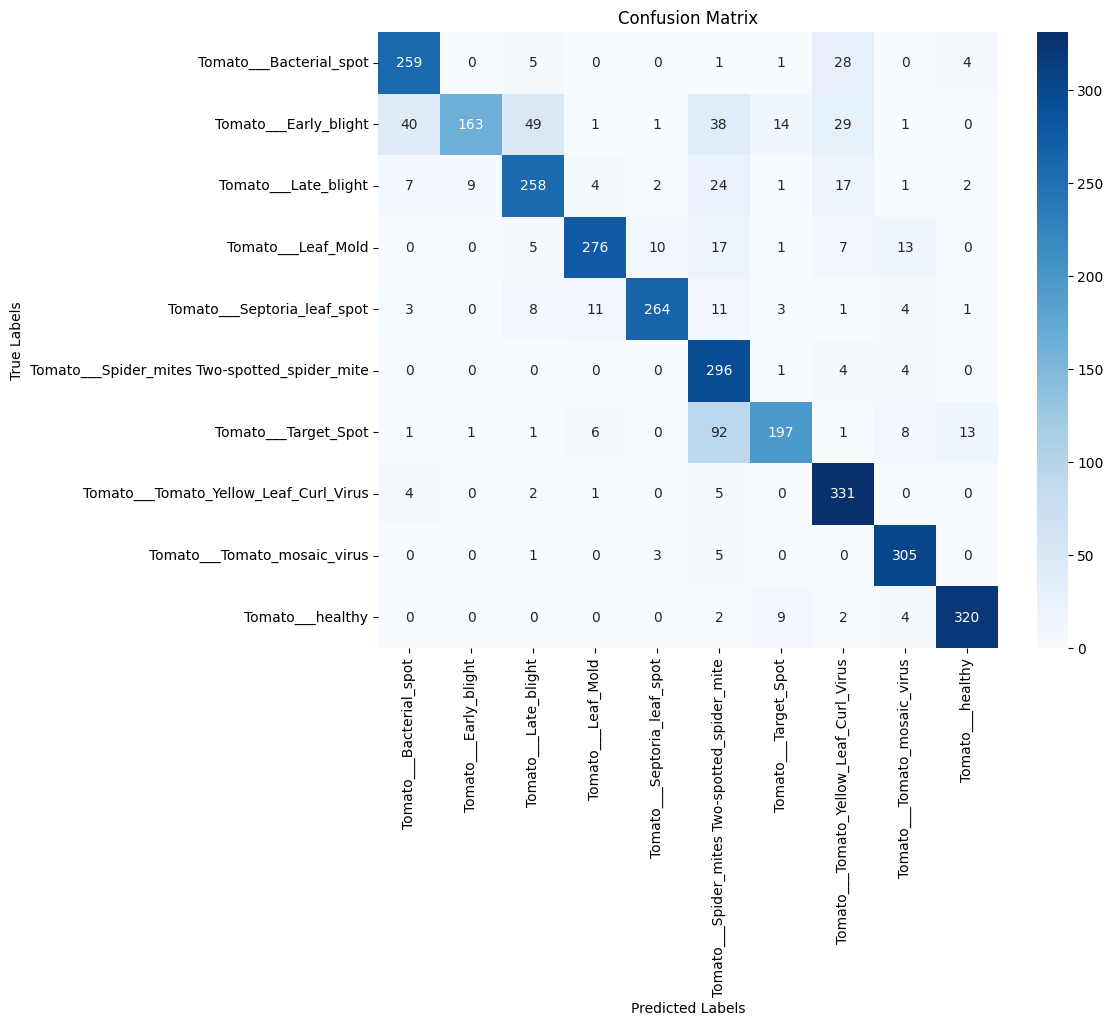

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.82      0.87      0.85       298
                        Tomato___Early_blight       0.94      0.49      0.64       336
                         Tomato___Late_blight       0.78      0.79      0.79       325
                           Tomato___Leaf_Mold       0.92      0.84      0.88       329
                  Tomato___Septoria_leaf_spot       0.94      0.86      0.90       306
Tomato___Spider_mites Two-spotted_spider_mite       0.60      0.97      0.74       305
                         Tomato___Target_Spot       0.87      0.62      0.72       320
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.79      0.97      0.87       343
                 Tomato___Tomato_mosaic_virus       0.90      0.97      0.93       314
                             Tomato___healthy       0.94      0.95      0.95       337

                                     accu

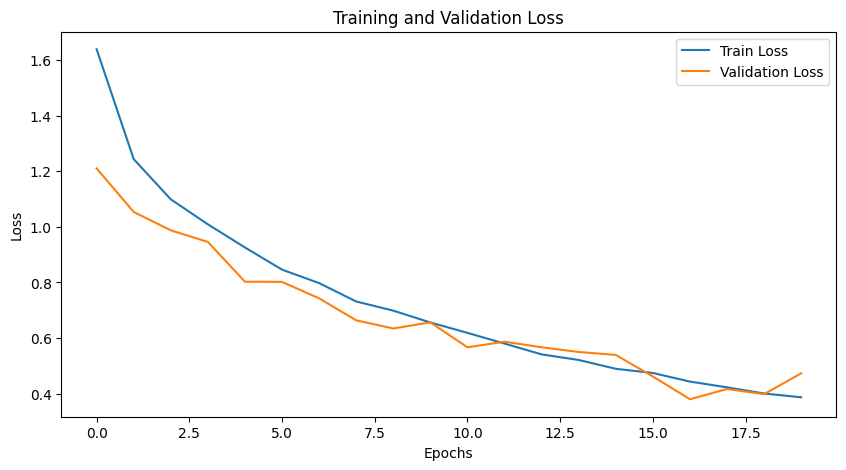

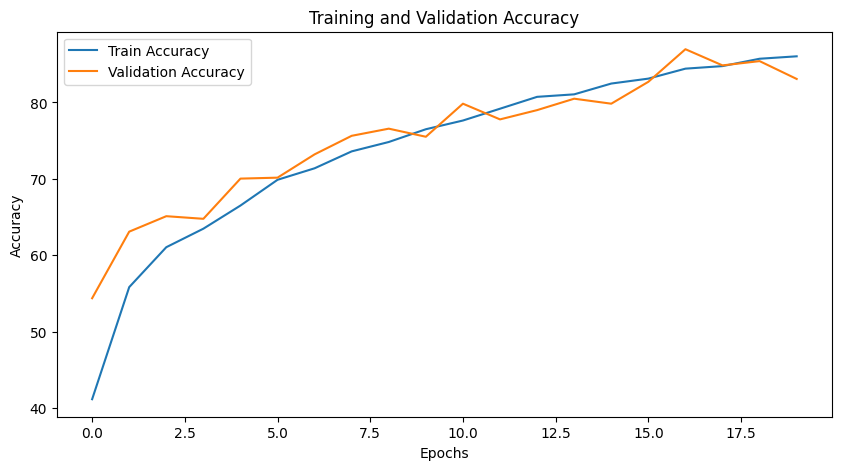

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel, ViTConfig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

train_path = 'D:/Publish Paper/ML in Cyber_ash/Plant_disease_detector/New Plant Diseases Dataset(Augmented)/train'
valid_path = 'D:/Publish Paper/ML in Cyber_ash/Plant_disease_detector/New Plant Diseases Dataset(Augmented)/valid'

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_path, transform=valid_transforms)

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# Configuration for ViT
config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel(config)


# Custom model
class CustomModel(nn.Module):
    def __init__(self, vit_model):
        super(CustomModel, self).__init__()
        self.vit_model = vit_model
        self.fc = nn.Linear(config.hidden_size, 10) 

    def forward(self, x):
        outputs = self.vit_model(x).pooler_output
        x = self.fc(outputs)
        return x


model = CustomModel(vit_model)

# Unfreeze the last few layers of the ViT model for fine-tuning
for param in vit_model.parameters():
    param.requires_grad = False

for param in vit_model.encoder.layer[-4:].parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': vit_model.encoder.layer[-4:].parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

# Training and validation
num_epochs = 20  # Increase the number of epochs
best_accuracy = 0.0
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validate the model
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    valid_losses.append(running_val_loss / len(valid_loader))
    valid_accuracies.append(100 * correct_val / total_val)

    accuracy = 100 * correct_val / total_val
    print(
        f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {valid_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, Validation Accuracy: {valid_accuracies[-1]}%")

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = train_data.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {accuracy * 100}%')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()